The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detect

# Defining utility functions

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog

import pickle
from collections import deque

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from joblib import Parallel, delayed

In [2]:
class Features(object):
    def __init__(self,
                 color_space='RGB',
                 spatial_size=(32, 32),
                 hist_bins=32,
                 orient=9,
                 pix_per_cell=8,
                 cell_per_block=2,
                 hog_channel=0,
                 spatial_feat=True,
                 hist_feat=True,
                 hog_feat=True,
                 hist_range=(0, 256)):
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = (pix_per_cell, pix_per_cell)
        self.cell_per_block = (cell_per_block, cell_per_block)
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.hist_range = hist_range

    @staticmethod
    def get_feature_image(img, color_space='RGB'):
        if color_space != 'RGB':
            return cv2.cvtColor(img, eval('cv2.COLOR_RGB2{}'.format(color_space)))
        else:
            return np.copy(img)

    def get_single_hog_features(self, img, vis=False, feature_vec=True):
        # Cell with two outputs if vis == True
        if vis == True:
            features, hog_image = hog(img,
                                      orientations=self.orient,
                                      pixels_per_cell=self.pix_per_cell,
                                      cells_per_block=self.cell_per_block,
                                      transform_sqrt=True,
                                      visualise=True,
                                      feature_vector=feature_vec,
                                      block_norm='L2')
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(img,
                           orientations=self.orient,
                           pixels_per_cell=self.pix_per_cell,
                           cells_per_block=self.cell_per_block,
                           transform_sqrt=True,
                           visualise=False,
                           feature_vector=feature_vec,
                           block_norm='L2')
        return features

    def get_hog_features(self, img):
        if self.hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(self.get_single_hog_features(img[:, :, channel], vis=False))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = self.get_single_hog_features(img[:, :, self.hog_channel], vis=False)
        return hog_features

    # Define a function to compute binned color features
    def bin_spatial(self, img):
        c1 = cv2.resize(img[:, :, 0], self.spatial_size).ravel()
        c2 = cv2.resize(img[:, :, 1], self.spatial_size).ravel()
        c3 = cv2.resize(img[:, :, 2], self.spatial_size).ravel()
        return np.hstack((c1, c2, c3))

    # Define a function to compute color histogram features
    # Need to change bins_range if reading .png files whit mpimg
    @staticmethod
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels sparately
        c1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
        c2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
        c3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to extarct features
    def extract_feature(self, img):
        file_features = []
        feature_image = self.get_feature_image(img, self.color_space)
        if self.spatial_feat == True:
            file_features.append(self.bin_spatial(feature_image))
        if self.hist_feat == True:
            file_features.append(self.color_hist(feature_image, bins_range=self.hist_range))
        if self.hog_feat == True:
            file_features.append(self.get_hog_features(feature_image))

        return np.concatenate(file_features)

# Porject Config

In [3]:
class config(object):
    color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8  # HOG pixels per cell
    cell_per_block = 2  # HOG cells per block
    hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32)  # Spatial binning dimensions
    hist_bins = 32  # Number of histogram bins
    spatial_feat = True  # Spatial features on or off
    hist_feat = True  # Histogram features on or off
    hog_feat = True  # HOG features on or off
    hist_range = (0, 256)  # histogram bins range
    y_start_stop_scale = [
        [350, 500, 1.0],
        [350, 500, 1.3],
        [360, 556, 1.4],
        [370, 556, 1.6],
        [380, 556, 1.8],
        [380, 556, 2.0],
        [390, 556, 1.9],
        [350, 556, 1.3],
        [350, 556, 2.2],
        [450, 656, 3.0]
    ]  # Min and max in y to search and the image scale
    svc_pickle = 'svc_pickle.p'  # Store the svc

    is_train = False  # If now running start with

    window = 64
    cells_per_step = 2  # define how many cells to step
    threshhold = 3  # Define the heatmap thershhold

    Features = Features(color_space=color_space,
                        orient=orient,
                        pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel,
                        spatial_size=spatial_size,
                        hist_bins=hist_bins,
                        spatial_feat=spatial_feat,
                        hist_feat=hist_feat,
                        hog_feat=hog_feat,
                        hist_range=hist_range)

# Example show train image

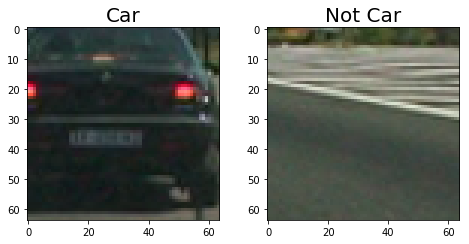

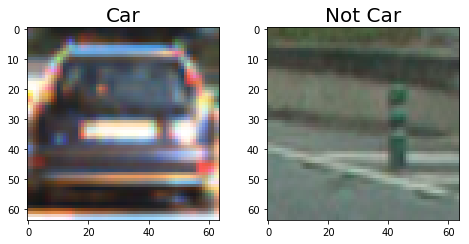

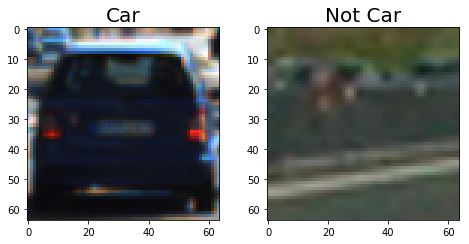

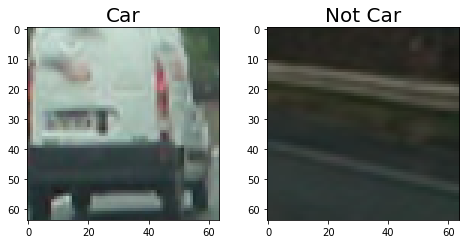

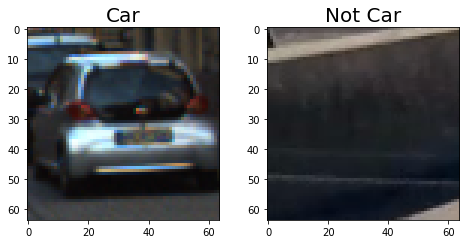

In [4]:
car_image_path = 'vehicles/*/*.png'
notcar_image_path = 'non-vehicles/*/*.png'
cars = glob.glob(car_image_path)
notcars = glob.glob(notcar_image_path)


def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

indices = np.random.randint(min(len(cars), len(notcars)), size=(5))
    
for i in indices:
    car_image = mpimg.imread(cars[i])
    notcar_image = mpimg.imread(notcars[i])
    compare_images(car_image, notcar_image, "Car", "Not Car")

## Show tain image features

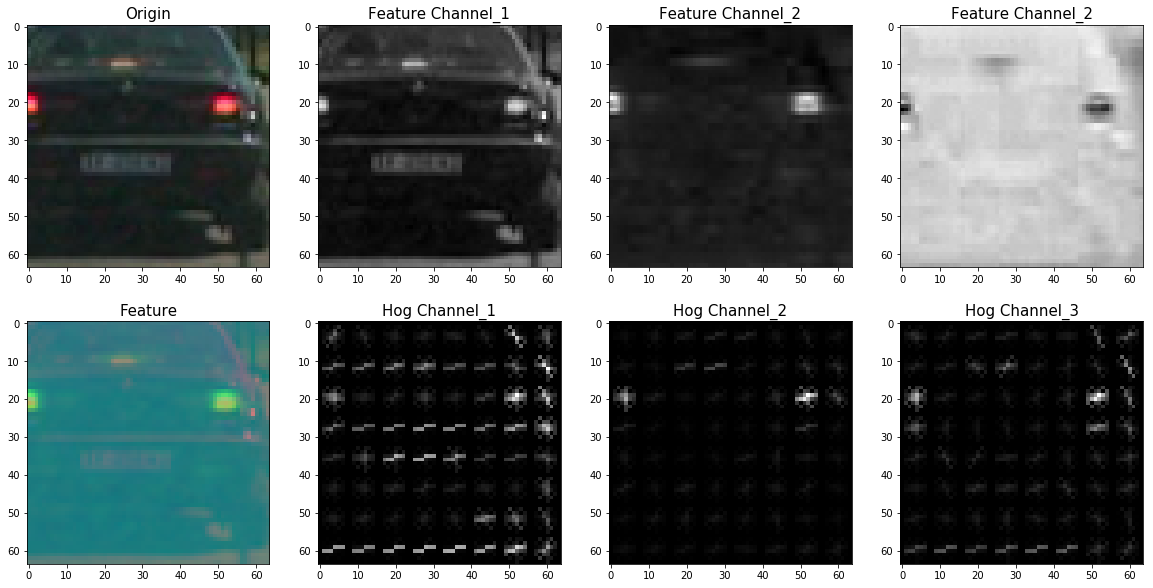

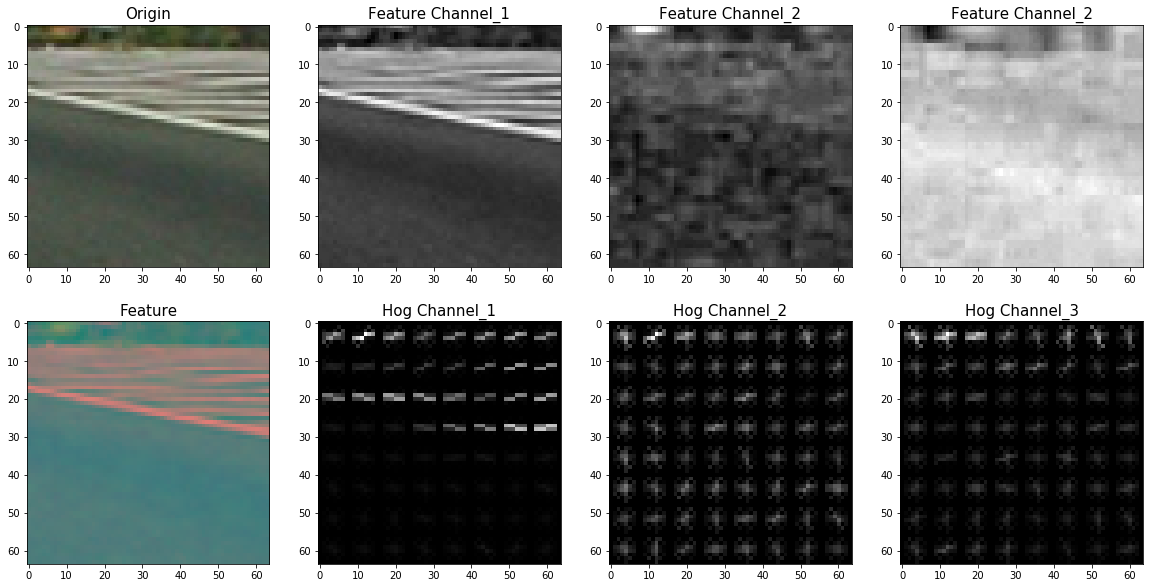

In [5]:
test_feature = config.Features
def show_images(image):
    feature = test_feature.get_feature_image(image, config.color_space)
    ch1 = feature[:,:,0]
    ch2 = feature[:,:,1]
    ch3 = feature[:,:,2]
    f, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs[0][0].imshow(image)
    axs[0][0].set_title('Origin', fontsize=15)
    axs[0][1].imshow(ch1, cmap='gray')
    axs[0][1].set_title('Feature Channel_1', fontsize=15)
    axs[0][2].imshow(ch2, cmap='gray')
    axs[0][2].set_title('Feature Channel_2', fontsize=15)
    axs[0][3].imshow(ch3, cmap='gray')
    axs[0][3].set_title('Feature Channel_2', fontsize=15)
    axs[1][0].imshow(feature)
    axs[1][0].set_title('Feature', fontsize=15)
    axs[1][1].imshow(test_feature.get_single_hog_features(ch1, vis=True)[1], cmap='gray')
    axs[1][1].set_title('Hog Channel_1', fontsize=15)
    axs[1][2].imshow(test_feature.get_single_hog_features(ch2, vis=True)[1], cmap='gray')
    axs[1][2].set_title('Hog Channel_2', fontsize=15)
    axs[1][3].imshow(test_feature.get_single_hog_features(ch3, vis=True)[1], cmap='gray')
    axs[1][3].set_title('Hog Channel_3', fontsize=15)
    plt.show()

car = mpimg.imread(cars[indices[0]])
notcar = mpimg.imread(notcars[indices[0]])
show_images(car)
show_images(notcar)

# Train Class

In [6]:
class Train(object):
    def __init__(self, cars, notcars):
        self.cars = cars
        self.notcars = notcars
        self.svc_pickle = config.svc_pickle
        self.Features = config.Features

    def get_features(self, file_list):
        file_features = []
        for img_file in file_list:
            # Image read and convert to RGB
            image = cv2.imread(img_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Append the extract features to the file features
            file_features.append(self.Features.extract_feature(image))
        return file_features

    def train(self):
        car_features = self.get_features(self.cars)
        notcar_features = self.get_features(self.notcars)
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        X_scaler = StandardScaler().fit(X)
        scaled_x = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test set
        X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=.2,
                                                            random_state=np.random.randint(0, 100))
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

        dist_pickle = {}
        dist_pickle["svc"] = svc
        dist_pickle["scaler"] = X_scaler
        pickle.dump(dist_pickle, open(self.svc_pickle, 'wb'))

In [7]:
def train_classify():
    car_image_path = 'vehicles/*/*.png'
    notcar_image_path = 'non-vehicles/*/*.png'
    cars = glob.glob(car_image_path)
    notcars = glob.glob(notcar_image_path)

    feature_train = Train(cars, notcars)
    feature_train.train()

train_classify()

Test Accuracy of SVC =  0.9944


# Preprocess Class

In [13]:
class Prepocess(object):
    def __init__(self):
        self.dist_pickle = pickle.load(open(config.svc_pickle, 'rb'))
        self.svc = self.dist_pickle['svc']
        self.X_scale = self.dist_pickle['scaler']
        self.Features = config.Features
        self.y_start_stop_scale = config.y_start_stop_scale
        self.color_space = config.color_space
        self.pix_per_cell = config.pix_per_cell
        self.orient = config.orient
        self.cell_per_block = config.cell_per_block
        self.window = config.window
        self.cell_per_step = config.cell_per_block
        self.threshhold = config.threshhold
        self.history = deque(maxlen=8)
        self.hog_channel = config.hog_channel

    def find_car_boxs(self, img, y_start, y_stop, scale):
        img = np.copy(img)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_tosearch = img[y_start:y_stop, :, :]
        # ctrans_tosearch = self.Features.get_feature_image(img_tosearch, self.color_space)
        ctrans_tosearch = self.Features.get_feature_image(img_tosearch, "YCrCb")
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                         (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

        h, w = ctrans_tosearch.shape[0], ctrans_tosearch.shape[1]

        # Define blocks and steps
        nxblocks = (w // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (h // self.pix_per_cell) - self.cell_per_block + 1
        nfeat_per_block = self.orient * self.cell_per_block ** 2

        nblocks_per_window = (self.window // self.pix_per_cell) - self.cell_per_block + 1
        nxsteps = (nxblocks - nblocks_per_window) // self.cell_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // self.cell_per_step + 1

        # Compute individual channel Hog features for the entire image
        if self.hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]
            hog1 = self.Features.get_single_hog_features(ch1, feature_vec=False)
            hog2 = self.Features.get_single_hog_features(ch2, feature_vec=False)
            hog3 = self.Features.get_single_hog_features(ch3, feature_vec=False)
            # hogs = Parallel(n_jobs=-1)(delayed(self.Features.get_single_hog_features)(x, feature_vec=False)
            #                                    for x in [ch1, ch2, ch3])
        else:
            ch = ctrans_tosearch[:, :, self.hog_channel]
            hog = self.Features.get_single_hog_features(ch, feature_vec=False)

        # Define the car boxs
        car_bboxs = []
        for xb in range(nxsteps):
            xpos = xb * self.cell_per_step
            xleft = xpos * self.pix_per_cell
            for yb in range(nysteps):
                ypos = yb * self.cell_per_step
                ytop = ypos * self.pix_per_cell
                # Extract Hog for this path
                if self.hog_channel == 'ALL':
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    # hog_features = [_hog[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    #                 for _hog in hogs]
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    # hog_features = np.hstack((hog_feat, hog_feat, hog_feat))
                    # hog_features = np.hstack((hog_features, hog_features, hog_features))

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+self.window, xleft:xleft+self.window], (64, 64))

                # Get color features
                spatial_features = self.Features.bin_spatial(subimg)
                hist_features = self.Features.color_hist(subimg)

                # Scale features and make a prediction
                test_features = self.X_scale.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                )
                test_prediction = self.svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(self.window * scale)

                    # Append the box to car_bboxs
                    car_bboxs.append(((xbox_left, ytop_draw + y_start),
                                      (xbox_left + win_draw, ytop_draw + win_draw + y_start)))

        return car_bboxs

    def apply_sliding_window(self, image):
        bboxes = []
        all_boxes = Parallel(n_jobs=-1, pre_dispatch='2*n_jobs')(delayed(self.find_car_boxs, check_pickle=False)(
            image, y_start, y_stop, scale) for y_start, y_stop, scale in self.y_start_stop_scale)
        for box in all_boxes:
            bboxes.extend(box)
        return bboxes

    def apply_sliding_window_sync(self, image):
        bboxes = []
        for y_start, y_stop, scale in self.y_start_stop_scale:
            bboxes.extend(self.find_car_boxs(image, y_start, y_stop, scale))

        draw_image = np.copy(image)
        for box in bboxes:
            cv2.rectangle(draw_image, box[0], box[1], (0, 0, 255), 2)

        return bboxes, draw_image

    def get_heatmap(self, image):
        """
        Create the heatmap
        """
        heatmap = np.zeros_like(image[:, :, 0]).astype(np.float)
        bboxes, draw_image = self.apply_sliding_window_sync(image)
        for box in bboxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" taks the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Zero out pixels below the threshhold
        heatmap[heatmap <= self.threshhold] = 0
        current_heatmap = np.clip(heatmap, 0, 255)
        self.history.append(current_heatmap)
        heat = np.zeros_like(current_heatmap).astype(np.float32)
        for _ in self.history:
            heat = heat + _
        return heat

    def draw_labeled_bboxs(self, image):
        """
        Draw the car box from the heatmap labels
        """
        lables = label(self.get_heatmap(image))
        for car_number in range(1, lables[1] + 1):
            # Find pixels with eatch car_number label value
            nonzero = (lables[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box base on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

        return image

    def draw_heatmap(self, image):
        """
        Use cv2.applyColorMap create heatmap image
        """
        heatmap = self.get_heatmap(image)
        return cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Example Preprocess Functions

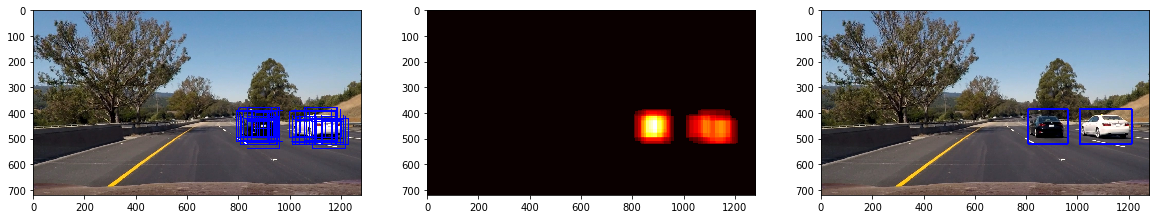

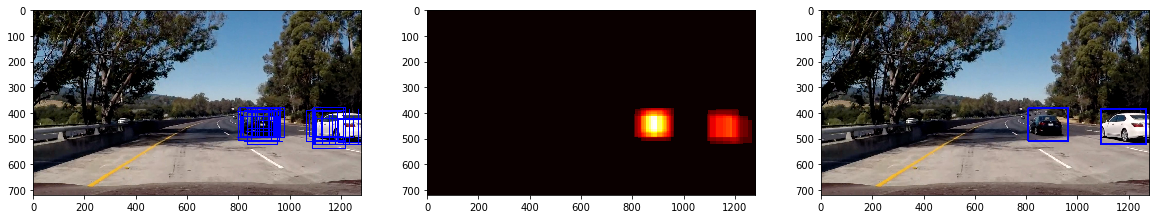

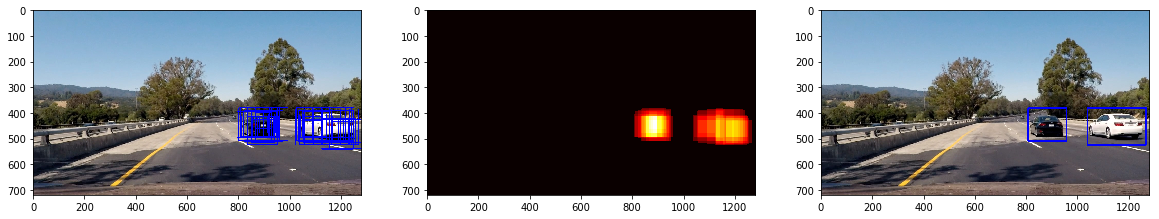

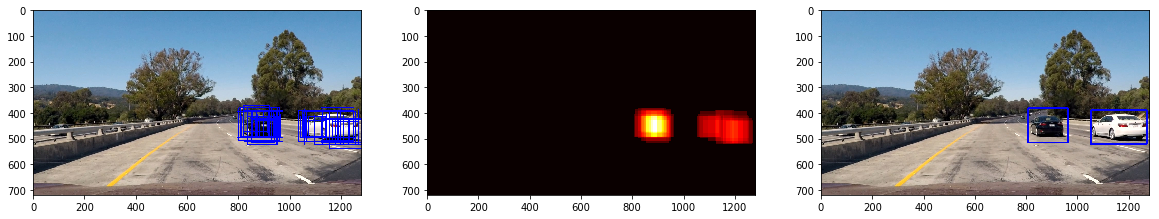

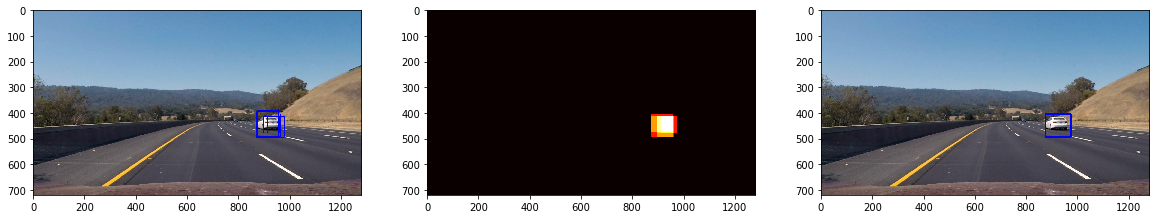

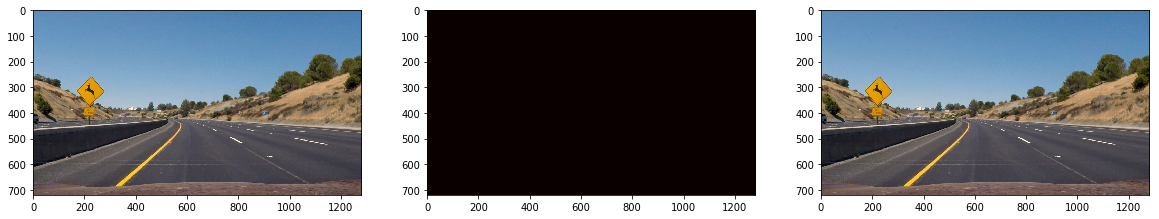

In [14]:
for img in glob.glob('test_images/*.jpg'):
    preprocess = Prepocess()
    image = mpimg.imread(img)
    bboxes, draw_image = preprocess.apply_sliding_window_sync(image)
    heat_map = preprocess.get_heatmap(image)
    lan_box = preprocess.draw_labeled_bboxs(image)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.imshow(draw_image)
    ax1.set_title('Slid Image', fontsize=15)
    ax2.imshow(heat_map, cmap='hot')
    ax2.set_title('Heatmap', fontsize=15)
    ax3.imshow(lan_box)
    ax3.set_title('Label Box', fontsize=15)
    plt.show()
    

In [15]:
preprocess = Prepocess().draw_labeled_bboxs
project_output = 'test_video_output.mp4'
clip = VideoFileClip('test_video.mp4')
project_clip = clip.fl_image(preprocess)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:31<00:02,  2.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [3]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">v
</video>
""".format('test_video_output.mp4'))

In [16]:
preprocess = Prepocess().draw_labeled_bboxs
project_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(preprocess)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [52:17<00:02,  2.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))